In [1]:
%matplotlib inline

In [3]:
import pandas
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

mars_df = pandas.read_csv('ns_110_4_1_data.csv')
mars_df['theta'] = mars_df['theta'] * 2 * np.pi / 360
mars_df['theta_error'] = mars_df['theta_error'] * 2 * np.pi / 360

RuntimeError: Python is not installed as a framework. The Mac OS X backend will not be able to function correctly if Python is not installed as a framework. See the Python documentation for more information on installing Python as a framework on Mac OS X. Please either reinstall Python as a framework, or try one of the other backends. If you are Working with Matplotlib in a virtual enviroment see 'Working with Matplotlib in Virtual environments' in the Matplotlib FAQ

In [34]:
for row in mars_df[['x', 'y']].itertuples():
    print row[1], row[2]

-1.45280334093 0.865357413193
-1.18475210358 0.705693597158
-1.29128528766 0.769149729172
-1.40812813471 0.838746777187
-1.43905712363 0.857169525192
-1.44902296427 0.850136723724
-1.63843908339 -0.0715357952792
-1.20795730142 -1.0028654735
1.30481563433 -0.449284053151
1.07642491174 0.986361703119
-0.178866927078 1.62015635739
-1.32134330006 1.02125015711
-1.61744743813 0.326134611626


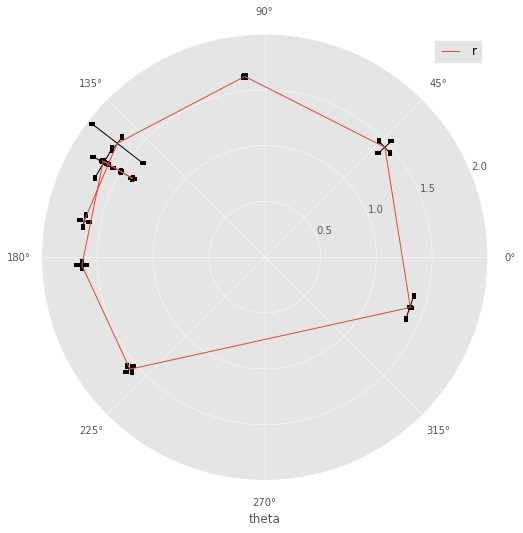

In [21]:
ax = plt.subplot(111, projection='polar')
mars_df.plot(x='theta', y='r', xerr='theta_error', yerr='r_error', kind='line',
             ax=ax, figsize=(8,8), grid=True, ecolor='black', capthick=4)
#ax.plot(mars_df['theta'], mars_df['r'])


In [ ]:
# From http://stackoverflow.com/questions/22959698/distance-from-given-point-to-given-ellipse

from math import sin, cos, atan2, pi, fabs


def ellipe_tan_dot(rx, ry, px, py, theta):
    '''Dot product of the equation of the line formed by the point
    with another point on the ellipse's boundary and the tangent of the ellipse
    at that point on the boundary.
    '''
    return ((rx ** 2 - ry ** 2) * cos(theta) * sin(theta) -
            px * rx * sin(theta) + py * ry * cos(theta))


def ellipe_tan_dot_derivative(rx, ry, px, py, theta):
    '''The derivative of ellipe_tan_dot.
    '''
    return ((rx ** 2 - ry ** 2) * (cos(theta) ** 2 - sin(theta) ** 2) -
            px * rx * cos(theta) - py * ry * sin(theta))


def estimate_distance(x, y, rx, ry, x0=0, y0=0, angle=0, error=1e-5):
    '''Given a point (x, y), and an ellipse with major - minor axis (rx, ry),
    its center at (x0, y0), and with a counter clockwise rotation of
    `angle` degrees, will return the distance between the ellipse and the
    closest point on the ellipses boundary.
    '''
    x -= x0
    y -= y0
    if angle:
        # rotate the points onto an ellipse whose rx, and ry lay on the x, y
        # axis
        angle = -pi / 180. * angle
        x, y = x * cos(angle) - y * sin(angle), x * sin(angle) + y * cos(angle)

    theta = atan2(rx * y, ry * x)
    while fabs(ellipe_tan_dot(rx, ry, x, y, theta)) > error:
        theta -= ellipe_tan_dot(
            rx, ry, x, y, theta) / \
            ellipe_tan_dot_derivative(rx, ry, x, y, theta)

    px, py = rx * cos(theta), ry * sin(theta)
    return ((x - px) ** 2 + (y - py) ** 2) ** .5

# http://nicky.vanforeest.com/misc/fitEllipse/fitEllipse.html would be a better approach


In [ ]:
from scipy.optimize import minimize

def ellipse_objective_function(params, data=mars_df):
    rx, ry = params # a and b in (x/a)^2 + (y/b)^2 = 1
    focus_center_distance = (rx ** 2 - ry ** 2) ** 0.5
    print focus_center_distance
    return sum([estimate_distance(row[1], row[2], rx, ry) for row in data[['x', 'y']].itertuples()])

ellipse_result = minimize(ellipse_objective_function, (1, 1), bounds=((0, None), (0, None)))

def circle_objective_function(r, data=mars_df):
    return sum([estimate_distance(row[1], row[2], r, r) for row in data[['x', 'y']].itertuples()])

circle_result = minimize(circle_objective_function, (1,), bounds=((0, None),))

print 'Ellipse:'
print ellipse_result
print '\nCircle:'
print circle_result

In [59]:
# from http://scipython.com/book/chapter-8-scipy/examples/non-linear-fitting-to-an-ellipse/
from scipy import optimize
import pylab

def f(theta, p):
    a, e, w = p
    return a * (1 - e**2)/(1 - e*np.cos(theta - w))

def residuals(p, r, theta):
    return r - f(theta, p)

def jac(p, r, theta):
    """ Calculate and return the Jacobian of residuals. """
    a, e, w = p
    da = (1 - e**2)/(1 - e*np.cos(theta - w))
    de = (-2*a*e*(1-e*np.cos(theta - w)) + a*(1-e**2)*np.cos(theta - w))/(1 -
                                                        e*np.cos(theta - w))**2
    dw = (a * e * (1.0 - e ** 2) * np.sin(theta - w)) / (1.0 + e * np.cos(theta - w)) ** 2
    return -da, -de, -dw
    return np.array((-da, -de, -dw)).T

p0 = (1, 0.5, -0.25)
plsq = optimize.leastsq(residuals, p0, Dfun=jac, args=(mars_df['r'], mars_df['theta']), col_deriv=True)
print(plsq)
ellipse_a, ellipse_e, ellipse_w = plsq[0]

(array([ 1.51306711, -0.0724507 , -0.45582832]), 1)


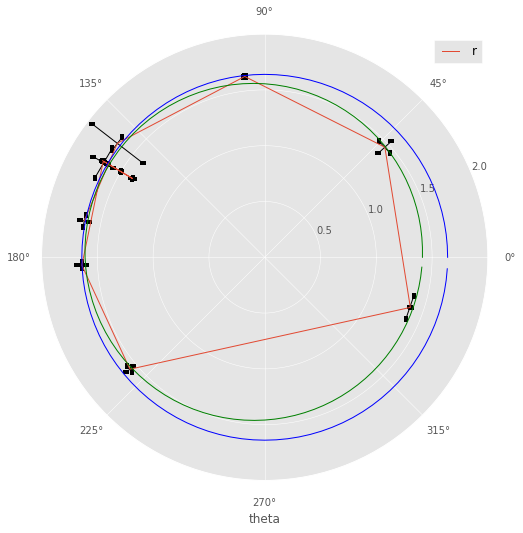

In [60]:
ax = plt.subplot(111, projection='polar')
mars_df.plot(x='theta', y='r', xerr='theta_error', yerr='r_error', kind='line',
             ax=ax, figsize=(8,8), grid=True, ecolor='black', capthick=4)

curve_theta = 2 * np.pi * np.arange(0, 1, 0.01)
ax.plot(curve_theta, [circle_result.x[0]] * len(curve_theta), color='blue')

def polar_ellipse(a, e, w, theta_values):
    return (a * (1.0 - e ** 2)) / (1.0 - e * np.cos(theta_values - ellipse_w)) 

ax.plot(curve_theta, polar_ellipse(ellipse_a, ellipse_e, ellipse_w, curve_theta), color='green')

In [1]:
circle_result.x

NameError: name 'circle_result' is not defined